In [66]:
import networkx as nx
import math
import pickle
from gplus_graph import GplusGraph
import operator
%matplotlib inline
import matplotlib.pyplot as plt

In [67]:
# Read a directed graph
graph = pickle.load(open('gplus_pickle_sample.p', 'r'))

In [68]:
# Calculate feature values of each node based on the set of metrics we use
# 1. Number of followers
# 2. Number of circles you are a part of in other people's circles
# 3. Sum of fractions of circles that you are a part of
# 4. Average of fractions of circles that you are a part of

def calculateFeatureValues(graph):
    for node, data in graph.nodes_iter(data=True):
        in_edges = graph.in_edges(node, data=True)
        total_circles = 0
        total_fraction = 0
        for n1, _, edata in in_edges:
            if 'circle' in edata:
                l = len(edata['circle'])
                total_circles += l
                total_fraction += (l * 1.0 / graph.node[n1]['num_circles'])
        
        data['followers'] = len(in_edges)
        data['in_circles'] = total_circles
        data['sum_circle_fraction'] = total_fraction
    
        #print graph.node[node]

In [69]:
# Feature weights
feature_weights = {}
feature_weights['followers'] = 0.01
feature_weights['in_circles'] = 0.39
feature_weights['sum_circle_fraction'] = 0.6

In [70]:
# Calculating the score for every node based on our metric
def calculateScores(graph):
    scores = {}
    non_gender_count = 0
    for node, data in graph.nodes_iter(data=True):
        if 'gender' not in data:
            pass
        else:
            score = 0
            for feature in feature_weights:
                score += feature_weights[feature] * data[feature]

            scores[node] = score
            #print "Node", node, "with gender", graph.node[node]['gender'], "had a score of", score, "using our metric"
        
    return scores

In [71]:
calculateFeatureValues(graph.g)
scores = calculateScores(graph.g)

In [72]:
gender_dict = {}
gender_dict['M'] = 0
gender_dict['F'] = 0
gender_dict['O'] = 0
googler_dict = {True: 0, False: 0}
total_googlers = {True: 0, False: 0}
total_genders = {'M': 0, 'F': 0, 'O': 0}
for node, score in scores.iteritems():
    gen = graph.g.node[node]['gender']
    gender_dict[gen] += score
    total_genders[gen] += 1
    
    goog = graph.g.node[node]['googler']
    googler_dict[goog] += score
    total_googlers[goog] += 1
    
for gen, score in gender_dict.iteritems():
    print gen, total_genders[gen], score * 1.0 / total_genders[gen]
    
for goog, score in googler_dict.iteritems():
    print goog, total_googlers[goog], score * 1.0 / total_googlers[goog]

M 21219 3.05346010651
O 7976 2.36921890672
F 6498 2.71971298861
False 35352 2.83047196764
True 341 3.80677419355


In [73]:
sorted_by_score = sorted(scores.items(), key=operator.itemgetter(1))

In [74]:
interval_fraction = 0.1
num_intervals = 1/interval_fraction
num_nodes = len(sorted_by_score)

intervals = []
intervals2 = []
for i in range(int(num_intervals)):
    nodes = [node for node, _ in sorted_by_score[int(interval_fraction*i*num_nodes): int(interval_fraction*(i+1)*num_nodes)]]
    new_dict = {"M": 0, "F": 0, "O": 0}
    new_goog_dict = {True: 0, False: 0}
    for node in nodes:
        new_dict[graph.g.node[node]['gender']] += 1
        new_goog_dict[graph.g.node[node]['googler']] += 1
    
    for gender in new_dict:
        new_dict[gender] = (new_dict[gender]*1.0 / len(nodes)) / (total_genders[gender]*1.0/num_nodes)
        
    for goog in new_goog_dict:
        new_goog_dict[goog] =  (new_goog_dict[goog]*1.0 / len(nodes)) / (total_googlers[goog]*1.0/num_nodes)
        
    intervals.append([new_dict['M'], new_dict['F'], new_dict['O']])
    intervals2.append([new_goog_dict[True], new_goog_dict[False]])


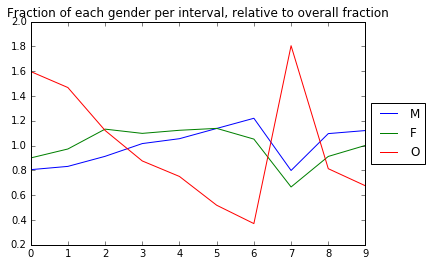

In [75]:
plt.plot(intervals)
plt.title('Fraction of each gender per interval, relative to overall fraction')
plt.legend(["M", "F", "O"], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

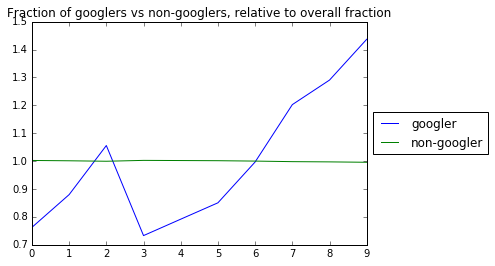

In [76]:
plt.plot(intervals2)
plt.title('Fraction of googlers vs non-googlers, relative to overall fraction')
plt.legend(["googler", "non-googler"], loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()